# 1. Library Imports

In [1]:
import pandas as pd

In [2]:
# import libraries
from pyspark.sql import SparkSession, Window, Column
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import MaxAbsScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from time import time
import re

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime

# 2. Understanding Dataset

In [4]:
file_path = "Data/full_data.json"

In [5]:
# create a Spark session and read JSON
spark = SparkSession \
        .builder \
        .appName("churn_pred") \
        .getOrCreate()
df = spark.read.json(file_path)

In [6]:
# get the list of columns and their value type
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# get data size
print("Data Shape = (", df.count(), ",", len(df.columns), ")")

Data Shape = ( 286500 , 18 )


In [8]:
# inspect data in row 1
df.show(1, truncate=False, vertical=True)

-RECORD 0---------------------------------------------------------------------------------
 artist        | Martha Tilston                                                           
 auth          | Logged In                                                                
 firstName     | Colin                                                                    
 gender        | M                                                                        
 itemInSession | 50                                                                       
 lastName      | Freeman                                                                  
 length        | 277.89016                                                                
 level         | paid                                                                     
 location      | Bakersfield, CA                                                          
 method        | PUT                                                                      

To further understand the data, we can look into the possible values for certain columns that are not as self-explanatory as the rest:

In [9]:
cols = [
    'page',
    'auth',
    'level',
    'method',
    'status',
#   'userAgent',
       ]
for col in cols:
    df.select(col).distinct().show(df.count(), truncate=False)

+-------------------------+
|page                     |
+-------------------------+
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|About                    |
|Settings                 |
|Login                    |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
|Cancel                   |
|Cancellation Confirmation|
|Submit Registration      |
|Register                 |
+-------------------------+

+----------+
|auth      |
+----------+
|Logged Out|
|Logged In |
|Cancelled |
|Guest     |
+----------+

+-----+
|level|
+-----+
|free |
|paid |
+-----+

+------+
|method|
+------+
|PUT   |
|GET   |
+------+

+------+
|status|
+------+
|307   |
|404   |
|200   |
+------+

### 2.1 Missing Data

Before we proceed further into data exploration, I would like to look into rows with missing data:

In [10]:
totcount = df.count()
print('')
for col in df.columns:
    missing = df.filter(df[col].isNull()).count()
    missfract = float(missing/totcount)
#    if missfract != 0:
    print(col, 'missing             \t', missfract, '%', missing)


artist missing             	 0.20381151832460734 % 58392
auth missing             	 0.0 % 0
firstName missing             	 0.029130890052356022 % 8346
gender missing             	 0.029130890052356022 % 8346
itemInSession missing             	 0.0 % 0
lastName missing             	 0.029130890052356022 % 8346
length missing             	 0.20381151832460734 % 58392
level missing             	 0.0 % 0
location missing             	 0.029130890052356022 % 8346
method missing             	 0.0 % 0
page missing             	 0.0 % 0
registration missing             	 0.029130890052356022 % 8346
sessionId missing             	 0.0 % 0
song missing             	 0.20381151832460734 % 58392
status missing             	 0.0 % 0
ts missing             	 0.0 % 0
userAgent missing             	 0.029130890052356022 % 8346
userId missing             	 0.0 % 0


### 2.2 User ID

Creating a new dataset on user level would mean that the key in the new dataframe would be the `userId`. Hence, we should ensure that the `userId` data is clean. This can be done by inspecting the possible values of this column

In [11]:
df.select('userId').distinct().sort('userId').show(df.count())

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
|100018|
|100019|
|100021|
|100022|
|100023|
|100024|
|100025|
|   101|
|   102|
|   103|
|   104|
|   105|
|   106|
|   107|
|   108|
|   109|
|    11|
|   110|
|   111|
|   112|
|   113|
|   114|
|   115|
|   116|
|   117|
|   118|
|   119|
|    12|
|   120|
|   121|
|   122|
|   123|
|   124|
|   125|
|   126|
|   127|
|   128|
|   129|
|    13|
|   131|
|   132|
|   133|
|   134|
|   135|
|   136|
|   137|
|   138|
|   139|
|    14|
|   140|
|   141|
|   142|
|   143|
|   144|
|   145|
|   146|
|   147|
|   148|
|   149|
|    15|
|   150|
|   151|
|   152|
|   153|
|   154|
|   155|
|   156|
|    16|
|    17|
|    18|
|    19|
|     2|
|    20|
|200001|
|200002|
|200003|
|200004|
|200005|
|200006|
|200007|
|200008|
|200009|
|200010|
|200011|
|200012|
|200014|
|200015|
|200016|
|

It seems that there are rows that have an empty string as their value for `userId`. Filtering some of these rows, we see that these are rows where users are accessing the page while logged out or using a guest account. The pages that they are able to access are generic pages that does not require an account. This means that these data can be safely ignored for this particular problem we are trying to solve.

In [12]:
df.filter(df['userId'] == '').toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged Out,None,None,100,None,NaN,free,None,GET,Home,NaN,8,None,200,1538355745000,None,
1,None,Logged Out,None,None,101,None,NaN,free,None,GET,Help,NaN,8,None,200,1538355807000,None,
2,None,Logged Out,None,None,102,None,NaN,free,None,GET,Home,NaN,8,None,200,1538355841000,None,
3,None,Logged Out,None,None,103,None,NaN,free,None,PUT,Login,NaN,8,None,307,1538355842000,None,
4,None,Logged Out,None,None,2,None,NaN,free,None,GET,Home,NaN,240,None,200,1538356678000,None,


In [13]:
df.filter(df['userId']=='').select('page').distinct().show()
df.filter(df['userId']=='').select('auth').distinct().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|              Login|
|               Help|
|              Error|
|Submit Registration|
|           Register|
+-------------------+

+----------+
|      auth|
+----------+
|Logged Out|
|     Guest|
+----------+



### 2.3 Error

Another column that caught my eye would be the `status` column, with `200` and `307` are successful requests, `404` means that there is an error in the request made. Facing errors or bugs on the platform could be a variable in leading customers to churn, hence I wanted to explore this feature more.

As there is a page named `Error` as well, I wanted to check that `status 404` is equivalent to `page Error`. Since the count is the same when filtered for each other, this means they are equivalent in this dataset. I also wanted to explore the pages that are accessed before these errors are faced to see if there would be any trend/pattern.

In [14]:
df.filter(df['page']=='Error').groupBy('status').count().show()
df.filter(df['status']=='404').groupBy('page').count().show()

+------+-----+
|status|count|
+------+-----+
|   404|  258|
+------+-----+

+-----+-----+
| page|count|
+-----+-----+
|Error|  258|
+-----+-----+



In [15]:
# Window specification to order rows by timestamp within each session
windowSpec = Window.partitionBy("sessionId").orderBy("ts")

# Add a lag column to get the previous row's page value
df2 = df.withColumn("prev_page", F.lag("page").over(windowSpec))

# Filter rows where the current page is 'error'
error_rows = df2.filter(df2.page == "Error")

# Get the previous page values (i.e., pages before 'error')
prev_pages = error_rows.select("sessionId", "prev_page")

# Count occurrences of each value in the 'prev_page' column, grouped by sessionId
page_counts = prev_pages.groupBy("prev_page").count()
page_counts.show()

+----------------+-----+
|       prev_page|count|
+----------------+-----+
|     Thumbs Down|    5|
|            Home|    8|
|     Roll Advert|    6|
|          Logout|    1|
|           About|    1|
|        Settings|    1|
|           Login|    3|
|      Add Friend|    9|
|        NextSong|  207|
|       Thumbs Up|   10|
|           Error|    1|
|Submit Downgrade|    1|
|       Downgrade|    2|
|            null|    1|
|         Upgrade|    2|
+----------------+-----+



### 2.4 Operating System

The next column that I wanted to investigate was the `userAgent` column to see if any feature engineering can be done. It contains information on the user's browser and operating system, since the application might have different performance on different systems, it might affect the user's experience on the application.

In [16]:
df.groupBy('userAgent').count().toPandas()

,userAgent,count
0,"""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537....",5238
1,Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0)...,62
2,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18448
3,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,3214
4,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) G...,5989
5,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,8624
6,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",7624
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,10300
8,None,8346
9,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_1 like...",1976


In [17]:
df.select('userAgent').distinct().show(df.count(), truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------+
|userAgent                                                                                                                                  |
+-------------------------------------------------------------------------------------------------------------------------------------------+
|"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                                   |
|Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0                                                                 |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                 |
|Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/20100101 Firefox/30.0                                                                   |
|Mozil

### 2.5 Location

In [18]:
df.groupBy('location').count().show(df.count(), truncate=False)

+---------------------------------------------+-----+
|location                                     |count|
+---------------------------------------------+-----+
|Gainesville, FL                              |1229 |
|Atlantic City-Hammonton, NJ                  |2176 |
|Kingsport-Bristol-Bristol, TN-VA             |1863 |
|New Haven-Milford, CT                        |4007 |
|Dubuque, IA                                  |651  |
|Las Vegas-Henderson-Paradise, NV             |2042 |
|Indianapolis-Carmel-Anderson, IN             |970  |
|Seattle-Tacoma-Bellevue, WA                  |246  |
|Winston-Salem, NC                            |819  |
|Bakersfield, CA                              |1775 |
|Los Angeles-Long Beach-Anaheim, CA           |30131|
|Minneapolis-St. Paul-Bloomington, MN-WI      |2134 |
|San Francisco-Oakland-Hayward, CA            |2647 |
|Phoenix-Mesa-Scottsdale, AZ                  |4846 |
|Allentown-Bethlehem-Easton, PA-NJ            |815  |
|Miami-Fort Lauderdale-West 

# 3. Data Pre-processing

Since we determined earlier that some logs do not have userID, we would first remove these logs.

In [19]:
df_valid = df.where(df.userId != "")

~8k rows of logs have been removed from the dataset.

In [20]:
print("Data Shape = (", df.count(), ",", len(df.columns), ")")
print("Data Shape = (", df_valid.count(), ",", len(df_valid.columns), ")")

Data Shape = ( 286500 , 18 )
Data Shape = ( 278154 , 18 )


However, as the number of data rows in the feature engineering is based on the number of unique `userId`, the actual amount of data we have to train and test the model would only be 225 rows.

In [21]:
df_valid.select('userId').distinct().count()

225

### 3.1 Define Churn

By definition, a user is considered churn if the user has had a value of Cancellation Confirmation under the attribute Page. This column would be the labels that our model is trying to predict. To try to understand the data, I checked the logs that contains cancellation confirmation to ensure that both paid and free users can churn.

In [22]:
df.where(df.page=="Cancellation Confirmation").toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Cancelled,Adriel,M,104,Mendoza,NaN,paid,"Kansas City, MO-KS",GET,Cancellation Confirmation,1535623466000,514,None,200,1538943990000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18
1,None,Cancelled,Diego,M,56,Mckee,NaN,paid,"Phoenix-Mesa-Scottsdale, AZ",GET,Cancellation Confirmation,1537167593000,540,None,200,1539033046000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",32
2,None,Cancelled,Mason,M,10,Hart,NaN,free,"Corpus Christi, TX",GET,Cancellation Confirmation,1533157139000,174,None,200,1539318918000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125
3,None,Cancelled,Alexander,M,332,Garcia,NaN,paid,"Indianapolis-Carmel-Anderson, IN",GET,Cancellation Confirmation,1536817381000,508,None,200,1539375441000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,105
4,None,Cancelled,Kayla,F,273,Johnson,NaN,paid,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",GET,Cancellation Confirmation,1538333829000,797,None,200,1539465584000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:24.0) G...,17
5,None,Cancelled,Molly,F,29,Harrison,NaN,free,"Virginia Beach-Norfolk-Newport News, VA-NC",GET,Cancellation Confirmation,1534255113000,843,None,200,1539588854000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",143
6,None,Cancelled,Alex,M,145,Hogan,NaN,paid,"Denver-Aurora-Lakewood, CO",GET,Cancellation Confirmation,1535066380000,842,None,200,1539729037000,Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) G...,101
7,None,Cancelled,Davis,M,34,Wang,NaN,paid,"Flint, MI",GET,Cancellation Confirmation,1538289776000,802,None,200,1539736161000,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",129
8,None,Cancelled,Nikolas,M,287,Olsen,NaN,paid,"Oxnard-Thousand Oaks-Ventura, CA",GET,Cancellation Confirmation,1528403713000,881,None,200,1539759749000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:31....,121
9,None,Cancelled,Ethan,M,176,Johnson,NaN,paid,"Lexington-Fayette, KY",GET,Cancellation Confirmation,1538080987000,934,None,200,1539761972000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",51


Looking at a specific user that churned, we see that they will go through the process of `Downgrade -> Cancel -> Cancellation Confirmation`. This means that these features should not be used in feature engineering as they will not help the model predict if a customer will churn.

In [23]:
df.where(df.userId==18).toPandas().tail(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
508,The Notorious B.I.G.,Logged In,Adriel,M,100,Mendoza,286.19710,paid,"Kansas City, MO-KS",PUT,NextSong,1535623466000,514,Nasty Girl (Featuring Diddy_ Nelly_ Jagged Edg...,200,1538943440000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18
509,Nickelback,Logged In,Adriel,M,101,Mendoza,207.46404,paid,"Kansas City, MO-KS",PUT,NextSong,1535623466000,514,Someday,200,1538943726000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18
510,None,Logged In,Adriel,M,102,Mendoza,NaN,paid,"Kansas City, MO-KS",GET,Downgrade,1535623466000,514,None,200,1538943739000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18
511,None,Logged In,Adriel,M,103,Mendoza,NaN,paid,"Kansas City, MO-KS",PUT,Cancel,1535623466000,514,None,307,1538943740000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18
512,None,Cancelled,Adriel,M,104,Mendoza,NaN,paid,"Kansas City, MO-KS",GET,Cancellation Confirmation,1535623466000,514,None,200,1538943990000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18


As the dataset is rather imbalanced, we would have to ensure that the labels are equally represented in both train and test datasets. This is especially important because the data size is rather small at only 225 data points.

In [24]:
churn_udf = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
churn = df_valid.select('userId', 'page')\
    .withColumn('page', churn_udf('page'))\
    .groupBy("userId")\
    .agg(F.max('page').alias("churn"))

churn.show(5)

+------+-----+
|userId|churn|
+------+-----+
|    51|    1|
|   124|    0|
|     7|    0|
|    54|    1|
|    15|    0|
+------+-----+
only showing top 5 rows



In [25]:
churn.groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



Another consideration before doing the train test split would be the time period this data is gathered over. This might affect the churn rate if a different version of the platform is released. I casted the timestamp to datetime and plot it in python to get the logs per date. It seems like the data is over a very short period of time, hence, datetime would not be a consideration when splitting the data into train-test.

In [26]:
df_pandas = df_valid.withColumn("datetime", F.to_timestamp(df_valid['ts']/1000).cast('string'))
df_pandas.show(1, vertical = True)

df_valid = df_valid.withColumn("datetime", F.to_timestamp(df_valid['ts']/1000))

-RECORD 0-----------------------------
 artist        | Martha Tilston       
 auth          | Logged In            
 firstName     | Colin                
 gender        | M                    
 itemInSession | 50                   
 lastName      | Freeman              
 length        | 277.89016            
 level         | paid                 
 location      | Bakersfield, CA      
 method        | PUT                  
 page          | NextSong             
 registration  | 1538173362000        
 sessionId     | 29                   
 song          | Rockpools            
 status        | 200                  
 ts            | 1538352117000        
 userAgent     | Mozilla/5.0 (Wind... 
 userId        | 30                   
 datetime      | 2018-10-01 08:01:57  
only showing top 1 row



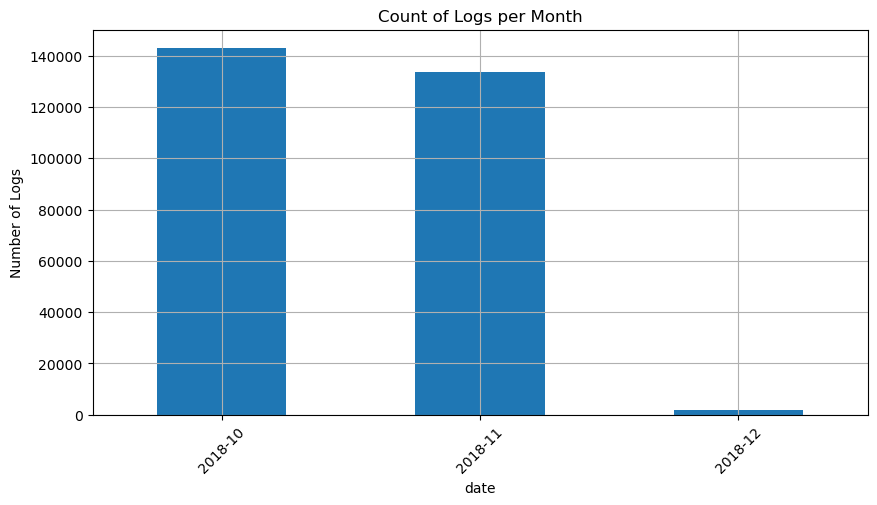

In [27]:
df_pandas = df_pandas.toPandas().astype({'datetime': 'datetime64[ns]'})
df_pandas['date'] = df_pandas['datetime'].dt.to_period('M')

# Group by 'date' and count the number of logs per month
logs_per_day = df_pandas.groupby('date').size()

# Plot the results
logs_per_day.plot(kind='bar', figsize=(10, 5))

# plt.xlabel('Date')
plt.ylabel('Number of Logs')
plt.title('Count of Logs per Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### 3.2 Train Test Split

The train test split has to be done manually to ensure that the labels are properly represented in both sample. `train_id` and `test_id` would return a dataframe with their respective user ids and their labels.

In [28]:
# Rename churn column into label
ds = churn.withColumn('label', churn['churn'].cast('float')).drop('churn') #important to have float type

In [29]:
zeros = ds.filter(ds["label"]==0)
ones = ds.filter(ds["label"]==1)

# split datasets into training and testing
train0, test0 = zeros.randomSplit([0.8,0.2], seed=1234)
train1, test1 = ones.randomSplit([0.8,0.2], seed=1234)

# stack datasets back together
train_id = train0.union(train1)
test_id = test0.union(test1)

Joining the previously dataframe with the dataset would let us filter the respective user ids along with their `churn` labels. This would be the train data that I will be working on for feature engineering.

In [30]:
train_df = df_valid.join(train_id, on="userId", how="right")
train_df.show(1, vertical = True)

-RECORD 0-----------------------------
 userId        | 100005               
 artist        | null                 
 auth          | Logged In            
 firstName     | Cason                
 gender        | M                    
 itemInSession | 0                    
 lastName      | Smith                
 length        | null                 
 level         | free                 
 location      | Monroe, LA           
 method        | GET                  
 page          | Home                 
 registration  | 1532610926000        
 sessionId     | 5                    
 song          | null                 
 status        | 200                  
 ts            | 1538407015000        
 userAgent     | "Mozilla/5.0 (Mac... 
 datetime      | 2018-10-01 23:16:55  
 label         | 1.0                  
only showing top 1 row



Here, I am converting the test data back into a json file, which I assume would be the format of incoming data that the model is used to predict for, to modularize the entire process with the json file being the input.

In [31]:
test_df = df_valid.join(test_id, on="userId", how="right").drop('label')
test_df.count()

73007

In [32]:
output_path = "data/test"
# test_df.coalesce(1).write.json(output_path)

# 4. Feature Engineering

### 4.1 Operating System Feature

Using the mapping that I got from an existing notebook for the operating system, I managed to extract the os data from the `userAgent` column. While my initial approach was to get the most used os across all the logs for each user, I realised that since there is no order for this category, using one-hot encoding would make the most sense. Hence, the `os` column has split into 3 separate columns.

I have also chose to not drop one of the hot encoded column (which is the common practice to avoid the dummy variable trap) because some users might have logs for multiple operating systems if they have multiple devices. 

In [33]:
# original mapping from : https://www.kaggle.com/code/chriskue/sparkify-user-churn-prediction
# map = {'Compatible': 'Windows', 'Ipad': 'iPad', 'Iphone': 'iPhone', 'Macintosh': 'Mac',  
#        'Windows nt 5.1': 'Windows', 'Windows nt 6.0': 'Windows', 'Windows nt 6.1': 'Windows', 
#        'Windows nt 6.2': 'Windows',  'Windows nt 6.3': 'Windows', 'X11': 'Linux'}

# original mapping for most common OS used
# os = df_valid.select('userId', 'userAgent')\
#     .withColumn('userAgent', os_udf('userAgent'))\
#     .groupBy("userId")\
#     .agg(F.mode('userAgent').alias("os"))\

def OperatingSystemFeature(df):
    '''
        This function creates a features with the os used by users
        
        INPUT: df - data frame with all the columns 
        OUTPUT: df - the data frame with the user id and the new feature(s)

    '''
    map = {'Compatible': 'Windows', 'Ipad': 'Mac', 'Iphone': 'Mac', 'Macintosh': 'Mac',  
       'Windows nt 5.1': 'Windows', 'Windows nt 6.0': 'Windows', 'Windows nt 6.1': 'Windows', 
       'Windows nt 6.2': 'Windows',  'Windows nt 6.3': 'Windows', 'X11': 'Linux'}

    # using regex to extract the first word in the first bracket 
    # and converting the column to one hot encoding for the 3 OS mappings
    
    os_udf = udf(lambda x: map[re.findall('\(([^\)]*)\)', x)[0].split(';')[0].capitalize()])
    win_udf = udf(lambda x: 1 if x == 'Windows' else 0, IntegerType())
    mac_udf = udf(lambda x: 1 if x == 'Mac' else 0, IntegerType())
    linux_udf = udf(lambda x: 1 if x == 'Linux' else 0, IntegerType())

    
    os = df.select('userId', 'userAgent')\
    .withColumn('userAgent', os_udf('userAgent'))\
    .withColumn('win', win_udf('userAgent'))\
    .withColumn('mac', mac_udf('userAgent'))\
    .withColumn('linux', linux_udf('userAgent'))\
    .groupBy("userId")\
    .agg(F.max('win').alias('win'),
         F.max('mac').alias('mac'),
         F.max('linux').alias('linux'),
        )

    return os

os = OperatingSystemFeature(train_df)
os.show(5)

+------+---+---+-----+
|userId|win|mac|linux|
+------+---+---+-----+
|100010|  0|  1|    0|
|200002|  0|  1|    0|
|     7|  1|  0|    0|
|    15|  1|  0|    0|
|100014|  1|  0|    0|
+------+---+---+-----+
only showing top 5 rows



### 4.2 Location Feature

As seen from the EDA section, it seems that there are logs with multiple states. While I initally wanted to consider adding state as a feature, it does not seem right to use one-hot encoding since there are so many possible states. There are no order in the states to use label encoding as well. 

Since the datasize is not big enough, it seems like more information on the dataset would be needed to decide if we should include location in the feature dataset. Maybe if different states have different pricing, they can be grouped into that respective category instead of specific states.

In [34]:
# extract state from location
location_udf = udf(lambda x:x[-2:])

location = train_df.select('userId', 'location')\
    .withColumn('location', location_udf('location'))\
    .groupBy("userId")\
    .agg(F.mode('location').alias("location"))

location.show(5)

+------+--------+
|userId|location|
+------+--------+
|    10|      MS|
|100001|      FL|
|100002|      CA|
|100004|      NY|
|100005|      LA|
+------+--------+
only showing top 5 rows



In [35]:
location.groupBy('location').count().show()

+--------+-----+
|location|count|
+--------+-----+
|      SC|    6|
|      AZ|    6|
|      LA|    1|
|      NJ|    1|
|      OR|    1|
|      VA|    3|
|      KY|    1|
|      NH|    5|
|      MI|    4|
|      NV|    3|
|      WI|    8|
|      ID|    1|
|      CA|   26|
|      CT|    6|
|      MT|    2|
|      NC|    7|
|      MD|    7|
|      MO|    1|
|      IL|    7|
|      WA|    3|
+--------+-----+
only showing top 20 rows



### 4.3 Gender

Additional data on the users that might be a variable to the churn rate:

In [36]:
def GenderFeature(df):
    '''
        This function creates a feature with the gender of the users, using mode to aggregate in case of edge cases
        
        INPUT: df - data frame with all the columns 
        OUTPUT: df - the data frame with the user id and the new feature(s)

    '''
    # udf to get one hot encoding for gender of users
    gender_udf = udf(lambda x: 1 if x=="M" else 0, IntegerType())
    
    gender = df.select('userId', 'gender')\
    .withColumn('gender', gender_udf('gender'))\
    .groupBy("userId")\
    .agg(F.mode('gender').alias("gender"))\

    return gender
    
gender = GenderFeature(train_df)
gender.show(5)

+------+------+
|userId|gender|
+------+------+
|    10|     1|
|100001|     0|
|100002|     0|
|100004|     0|
|100005|     1|
+------+------+
only showing top 5 rows



### 4.4 Levels (Free vs Paid)

For the `levels` data, I come up with the following possible features:
1. Most recent level
2. the age of the account in days
3. the number of days the account is at the paid level
4. the % of time that the account is active when it is at the paid level

As we have determined above that both paid and free users can cancel their subscription, this should be an important factor in the churn prediction. Paid vs free users churn should have different factors in play for the customers, hence, ideally they should be modelled separately. However, due to the size of the dataset, it does not seem practical to further split it into 2 different categories.

As users go through different period of being paid and free, this could be a feature that can give insight into customers churning. The first feature in this section is the most recent level for each account before the churn.

In [37]:
def RecentAccLevel(df):
    '''
        This function creates a feature with the most recent level of each account per user id

        INPUT: df - data frame with all the columns 
        OUTPUT: df - the data frame with the user id and the new feature(s)
        

    '''
    # udf to get binary labels for levels
    levels_udf = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())

    recentAccLevel = df.select(['userId', 'level', 'ts'])\
        .orderBy(desc('ts'))\
        .dropDuplicates(['userId'])\
        .select(['userId', 'level'])\
        .withColumn('level', levels_udf('level').cast(IntegerType()))
    
    return recentAccLevel

accLevel = RecentAccLevel(train_df)
accLevel.show(5)

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|100001|    0|
|100002|    1|
|100004|    1|
|100005|    0|
+------+-----+
only showing top 5 rows



Other possible features that can be generated would be the account age, as well as how long the account has had a premium subscription. This is to differentiate the different levels of users from each other.

In [38]:
def AccPaidLevel(df):
    '''
        This function creates the following features:
        1. the age of the account in days
        2. the number of days the account is at the paid level
        3. the % of time that the account is active when it is at the paid level

        INPUT: df - data frame with all the columns 
        OUTPUT: df - the data frame with the user id and the new feature(s)
        

    '''
    # udf to get fraction of time that each account has a paid subscription
    def func(daysPaid, accAge):
        return daysPaid/accAge
        
    daysPaidProportion_udf = udf(func, FloatType())

    
    daysPaid = df.filter(df.level=='paid') \
        .groupBy('userId') \
        .agg(max('ts').alias('max'),min('ts').alias('min'),max('registration').alias("registration")) \
        .withColumn('accAge', F.round((F.col('max') - F.col('registration'))/(24*3600*1000),2))\
        .withColumn('daysPaid', F.round((F.col('max') - F.col('min'))/(24*3600*1000),2) ) \
        .withColumn('daysPaidProportion', F.round(daysPaidProportion_udf("daysPaid","accAge"),2))\
        .select('userId','daysPaid','accAge','daysPaidProportion')

    return daysPaid

daysPaid = AccPaidLevel(train_df)
daysPaid.show(5)

+------+--------+------+------------------+
|userId|daysPaid|accAge|daysPaidProportion|
+------+--------+------+------------------+
|200002|   28.58| 70.07|              0.41|
|    15|   54.77| 56.51|              0.97|
|   132|   50.42| 66.89|              0.75|
|    11|   47.14|124.48|              0.38|
|   138|   39.47| 66.63|              0.59|
+------+--------+------+------------------+
only showing top 5 rows



### 4.5 Statistics from Pages

For the `page` data, I have come up with the following possible features:
1. Liked Songs Count
2. Disliked Songs Count
3. Percentage of songs disliked
4. Friends Count
5. Error Count Per Hour
2. Advert Count Per Hour
3. Total Session Length in hours
4. Average Session Length in hours
5. Number of Sessions

The number of likes and dislikes can give insights into the satisfaction of the customer for the platform. However, as these numbers can be inflated if certain users are very active on the platform compared to other users, I have also included the percentage of songs disliked over the total number of ratings given by the customer.

In [39]:
def LikedSongsFeature(df):
    '''
        This function calculates the following features:
        1. the number of liked songs
        2. the number of disliked songs
        3. the % of songs disliked

        
        INPUT: df - data frame with all the columns 
        OUTPUT: df - the data frame with the user id and the new feature(s)


    '''
    # udfs to get binary label for thumbs up and thumbs down pages
    like_udf = udf(lambda x: 1 if x == 'Thumbs Up' else 0, IntegerType())
    dislike_udf = udf(lambda x: 1 if x == 'Thumbs Down' else 0, IntegerType())

    likes = df.withColumn('thumbsUp', like_udf('page')) \
        .withColumn('thumbsDown', dislike_udf('page'))\
        .groupBy('userId')\
        .agg(F.sum('thumbsUp').alias("thumbsUp"),F.sum('thumbsDown').alias("thumbsDown")) \
        .withColumn('thumbsDownProportion', F.round(F.col('thumbsDown') / (F.col('thumbsUp')+F.col('thumbsDown')),2)) \
    
    
    return likes

likes = LikedSongsFeature(train_df)
likes.show(5)

+------+--------+----------+--------------------+
|userId|thumbsUp|thumbsDown|thumbsDownProportion|
+------+--------+----------+--------------------+
|100010|      17|         5|                0.23|
|200002|      21|         6|                0.22|
|     7|       7|         1|                0.13|
|    15|      81|        14|                0.15|
|100014|      17|         3|                0.15|
+------+--------+----------+--------------------+
only showing top 5 rows



Based on similar music platforms, if this platform has plans that can be shared or features where you can interact with your friends, this could be a factor for customers in deciding whether to continue their subscription. Hence, `NumberOfFriendsFeature` will determine the number of times the users navigate to the `Add Friend` page

In [40]:
def NumberOfFriendsFeature(df):
    '''
        This function calculates the number of friends added by the user
        
        INPUT: originalDataset - original data frame with all the columns 
               modelDataset - the data frame with the other features
        OUTPUT: modelDataset - the data frame with the other features and the new feature


    '''
    friend_udf = udf(lambda x: 1 if x == 'Add Friend' else 0, IntegerType())
    
    friend = df.withColumn('friendCount', friend_udf('page'))\
            .groupBy('userId')\
            .agg(F.sum('friendCount').alias("friendCount")) 
    
    return friend

friend = NumberOfFriendsFeature(train_df)
friend.show(5)

+------+-----------+
|userId|friendCount|
+------+-----------+
|100010|          4|
|200002|          4|
|     7|          1|
|    15|         31|
|100014|          6|
+------+-----------+
only showing top 5 rows



Errors and advertisments can contribute negatively to the users experience as well. Hence, the number of errors and advertistments per hour could be a feature. The amount of usage of the platform from the users, as well as their habits can be tracked through the data on each sessions. This would give us insights into the users' habits when using the platform.

Another feature to consider might be the users usage data over time, as it is expected that users will reduce their usage near the end of their subscription. However, the time period for this data is very short and we would need to study the users usage pattern more in depth over longer periods of time to determine the threshold for this usage reduction. This could be done with more data over longer periods of time.

In [41]:
def SessionFeature(df):
    '''
        This function calculates the following features:
        1. Error Count Per Hour
        2. Advert Count Per Hour
        3. Total Session Length in hours
        4. Average Session Length in hours
        5. Number of Sessions
        
        INPUT: originalDataset - original data frame with all the columns 
               modelDataset - the data frame with the other features
        OUTPUT: modelDataset - the data frame with the other features and the new feature


    '''

    ad_udf = udf(lambda x: 1 if x=="Roll Advert" else 0, IntegerType())
    err_udf = udf(lambda x: 1 if x=="Error" else 0, IntegerType())
    
    
    def func(count, sessionLengthHr):
        return count/sessionLengthHr
        
    count_udf = udf(func, FloatType())
    
    errors = df.withColumn('err', err_udf('page'))\
            .withColumn('ad', ad_udf('page'))\
            .groupBy('userId','sessionId') \
            .agg(max('ts').alias('max'),min('ts').alias('min'),F.max('ts').alias("ts"), F.sum('err').alias('errCount'),F.sum('ad').alias('adCount'))\
            .withColumn('sessionLengthHr', F.round((F.col('max') - F.col('min'))/(3600*1000),2))
    
    errors = errors.select('userId','errCount','adcount','sessionLengthHr')\
            .groupBy('userId')\
            .agg(F.sum('errCount').alias('errCount'),F.sum('adCount').alias('adCount'), F.round(F.sum('sessionLengthHr'),2).alias('totalSessionLengthHours'), F.round(F.mean('sessionLengthHr'),2).alias('avgSessionLengthHours'),F.count('sessionLengthHr').alias('noOfSessions'))\
            .withColumn('errCountPerHour', F.round(count_udf("errCount","totalSessionLengthHours"),2))\
            .withColumn('adCountPerHour', F.round(count_udf("adCount","totalSessionLengthHours"),2))\
            .select('userId','errCountPerHour','adcountPerHour','totalSessionLengthHours','avgSessionLengthHours','noOfSessions')
    return errors
    
session = SessionFeature(train_df)
session.show(5)

+------+---------------+--------------+-----------------------+---------------------+------------+
|userId|errCountPerHour|adcountPerHour|totalSessionLengthHours|avgSessionLengthHours|noOfSessions|
+------+---------------+--------------+-----------------------+---------------------+------------+
|100010|            0.0|          2.89|                  18.01|                 2.57|           7|
|200002|            0.0|          0.26|                  26.64|                 4.44|           6|
|     7|            0.1|          1.56|                  10.24|                 1.46|           7|
|    15|           0.02|          0.01|                 132.07|                  8.8|          15|
|100014|            0.0|          0.11|                  18.49|                 3.08|           6|
+------+---------------+--------------+-----------------------+---------------------+------------+
only showing top 5 rows



### 4.6 Combined features dataset

Combining each of the functions above to get all the features into one dataset as training/test data for the model:

This is the list of all the features in the new dataset:

Feature | Description 
---:|:---:
**userId** | Unique identifier for each user 
**label** | 1 = churn, 0 = not churn  
**win** | 1 = used window as operating system \| 0 = did not  
**mac** | 1 = used mac as operating system \| 0 = did not 
**linux** | 1 = used linux as operating system \| 0 = did not 
**gender** | 1 = male \| 0 = female
**level** | for most recent account level, 1 = paid \| 0 = free
**daysPaid** | the number of days the account is at the paid level
**accAge** | the age of the account in days
**daysPaidProportion** | the percentage of time that the account is active when it is at the paid level 
**thumbsUp** | the number of thumbs up given
**thumbsDown** | the number of thumbs down given
**thumbsDownProportion** | the percentage of thumbs down given over all ratings 
**friendCount** | the number of friends 
**errCountPerHour** | the number of errors faced per hour 
**adcountPerHour** | the number of advertisements faced per hour
**totalSessionLengthHours** | the total number of sessions length 
**avgSessionLengthHours** | the average of each session length
**noOfSessions** | the total number of sessions

In [42]:
def dataProcessing(df, id):
    '''
        This function generates the features dataset from the dataframe and list of user ids with labels
        
        INPUT: df - data frame with all the columns from the original dataset
               id - data frame containing user ids from the dataset and their binary churn label
        OUTPUT: dataset - the data frame with all the features and label


    '''
    os = OperatingSystemFeature(df)
    gender = GenderFeature(df)
    accLevel = RecentAccLevel(df)
    daysPaid = AccPaidLevel(df)
    likes = LikedSongsFeature(df)
    friend = NumberOfFriendsFeature(df)
    session = SessionFeature(df)

    dataset = id.join(os,['userId'])\
        .join(gender,['userId'])\
        .join(accLevel,['userId'])\
        .join(daysPaid,['userId'])\
        .join(likes,['userId'])\
        .join(friend,['userId'])\
        .join(session,['userId'])

    return dataset

train_ds = dataProcessing(train_df, train_id)
test_df = df_valid.join(test_id, on="userId", how="right")
test_ds = dataProcessing(test_df, test_id)

In order to facilitate the data preprocessing for new test data, the following function is able to generate the features dataset from the filepath of the json test data. This assumes that the data is in the right format but there should be data validation at the start of this function otherwise.

In [ ]:
def getFeatures(file_path):
    '''
        This function generates the features dataset from the file path of the original dataset
        
        INPUT: file path - file path of the json file containing the dataset
        OUTPUT: dataset - the data frame with all the features and label


    '''
    spark = SparkSession \
        .builder \
        .appName("churn_pred") \
        .getOrCreate()
    df = spark.read.json(file_path)

    df_valid = df.where(df.userId != "")

    churn_udf = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
    churn = df_valid.select('userId', 'page')\
        .withColumn('page', churn_udf('page'))\
        .groupBy("userId")\
        .agg(F.max('page').alias("label"))
    
    ds = dataProcessing(df_valid, churn)
    return ds

# file_path = 'data/test_data.json'
# ds = getFeatures(file_path)

In [59]:
train_ds.show(1, vertical = True)

-RECORD 0-------------------------
 userId                  | 200002 
 label                   | 0.0    
 win                     | 0      
 mac                     | 1      
 linux                   | 0      
 gender                  | 1      
 level                   | 1      
 daysPaid                | 28.58  
 accAge                  | 70.07  
 daysPaidProportion      | 0.41   
 thumbsUp                | 21     
 thumbsDown              | 6      
 thumbsDownProportion    | 0.22   
 friendCount             | 4      
 errCountPerHour         | 0.0    
 adcountPerHour          | 0.26   
 totalSessionLengthHours | 26.64  
 avgSessionLengthHours   | 4.44   
 noOfSessions            | 6      
only showing top 1 row



In [60]:
test_ds.show(1, vertical = True)

-RECORD 0-------------------------
 userId                  | 124    
 label                   | 0.0    
 win                     | 0      
 mac                     | 1      
 linux                   | 0      
 gender                  | 0      
 level                   | 1      
 daysPaid                | 60.0   
 accAge                  | 131.56 
 daysPaidProportion      | 0.46   
 thumbsUp                | 171    
 thumbsDown              | 41     
 thumbsDownProportion    | 0.19   
 friendCount             | 74     
 errCountPerHour         | 0.02   
 adcountPerHour          | 0.01   
 totalSessionLengthHours | 279.85 
 avgSessionLengthHours   | 9.65   
 noOfSessions            | 29     
only showing top 1 row



# 5. Model

Using the dataset above to train certain models:

Since the dataset is quite small, we will be using statistical models rather than overly complex neural networks. Furthermore, we would be implementing cross-validation to maximise the limited data that we have. With smaller datasets, model performance can be highly sensitive to the specific split of data. This can also be mitigated by using cross validation.

The dataset is also fairly imbalanced, with ~23% churn vs no churn. Hence, we would have to ensure that the metrics used to evaluate and fine-tune the model takes this into account. This is so that it will not simply predict all as the majority class to get a decent accuracy. One such metric that we can use is the F1 Score, which is the harmonic mean of precision and recall. By considering both false positives and false negatives, the F1 score is more sensitive to the performance of the minority class.

In [57]:
# Dropping the userId and label columns for the train and test dataset
feature_cols = train_ds.drop('label').drop('userId').columns

In [46]:
# Dropping the userId columns for the train and test dataset
train = train_ds.drop('userId')
test = test_ds.drop('userId')

Building the cross validation pipeline, we first have the vector assembler which combines the feature columns into a single vector column. Then, we use the MaxAbsScaler to normalize the features of the model, since the data can be very sparse for some features. The metric that we chose to use would be the F1-Score as explained earlier.

Since the dataset is pretty small, we would have to use a lower number of fold to ensure that the model does not overfit. Too few folds, such as 2-fold, might lead to higher bias, hence, the use of 3-fold for this dataset.

In [47]:
def buildCV(classifier, paramGrid):
    '''
    Build a cross validation pipeline
    
    INPUT
    classifier: untrained machine learning classifier
    paramGrid: a grid of parameters to search over
    
    OUTPUT
    crossval: cross validator
    '''
    # Configure an ML pipeline
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="rawFeatures")
    scaler = MaxAbsScaler(inputCol="rawFeatures", outputCol="scaledFeatures")
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    # Cross validation
    crossval = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=MulticlassClassificationEvaluator(metricName='f1'),
        numFolds=3
    )
    return crossval

In [48]:
def trainModel(classifier, train, paramGrid):
    '''
    Train the machine learning model
    
    INPUT
    classifier: untrained machine learning classifier
    paramGrid: a grid of parameters to search over
    train (Spark dataframe): training dataset
    
    OUTPUT
    model: trained machine learning model
    training_time (float): training time
    '''
    crossval = buildCV(classifier, paramGrid)
    start = time()
    model = crossval.fit(train)
    end = time()
    training_time = end - start
    return model, training_time

Getting the model's performance on both training and testing dataset to understand if it is generalizing well.

In [49]:
def evaluateModel(model, data, prob=False):
    '''
    Evaluate model performance
    
    INPUT
    model: trained machine learning model
    data (Spark dataframe): either training set or testing set
    
    OUTPUT
    evalMetrics (dict): disctionary of evaluation metrics
    '''
    # Make prediction
    start = time()
    pred = model.transform(data)

    # Evaluator selector, if the model outputs probability or prediction
    if prob:
        evaluator = MulticlassClassificationEvaluator(predictionCol="probability", labelCol="label")
    else:
        evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
    end = time()
    prediction_time = end - start
    
    # Calculate metrics
    evalMetrics = {}
    evalMetrics["precision"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedPrecision"})
    evalMetrics["recall"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedRecall"})
    evalMetrics["f1"] = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    evalMetrics["accuracy"] = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
    evalMetrics['confusion_matrix'] = pred.groupby("label").pivot("prediction").count()
    evalMetrics['prediction_time'] = prediction_time
    
    return evalMetrics

In [ ]:
def evaluateTrainTest(model, train, test, training_time):
    '''
    Evaluate model performance on both training and testing sets
    
    INPUT
    model: trained machine learning model
    train: training set
    test: testing set
    training_time (float): training time
    
    OUTPUT
    evalMetrics (dict): disctionary of evaluation metrics, 
        compiled from training, testing metrics
    summary (Spark dataframe): table of evaluation metrics
    '''
    # Evaluate model performance
    evalMetricsTraining = evaluateModel(model, train)
    evalMetricsTesting = evaluateModel(model, test)

    # Compile metrics
    evalMetrics = {}
    evalMetrics['train_time'] = training_time
    evalMetrics['f1_train'] = evalMetricsTraining['f1']
    evalMetrics['acc_train'] = evalMetricsTraining['accuracy']
    evalMetrics['f1_test'] = evalMetricsTesting['f1']
    evalMetrics['acc_test'] = evalMetricsTesting['accuracy']
    evalMetrics['pred_time'] = evalMetricsTraining['prediction_time'] \
        + evalMetricsTesting['prediction_time']

    # Summarize metrics into a Spark dataframe
    metrics_to_display = {
        k:round(v, 4) for k,v in evalMetrics.items() if ('confusion_matrix' not in k)
    }
    summary = spark.createDataFrame(pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys()))
    
    return evalMetrics, summary

Combining the above functions to take in the data inputs and output the model summary

In [55]:
def trainAndEval(classifier, train, test, paramGrid):
    '''
    Train and evaluate model performance on both training and testing sets
    
    INPUT
    classifier: untrained machine learning classifier
    train: training set
    test: testing set
    paramGrid: a grid of parameters to search over
    
    OUTPUT
    evalMetrics (dict): disctionary of evaluation metrics, 
        compiled from training, testing metrics
    summary (Spark dataframe): table of evaluation metrics
    model: trained machine learning model
    '''
    print('training model...')
    # Train the model
    model, training_time = trainModel(classifier, train, paramGrid)

    print('evaluating model training...')
    # Evaluate model performance
    evalMetricsTraining = evaluateModel(model, train)


    print('evaluating model testing...')
    evalMetricsTesting = evaluateModel(model, test)

    # Compile metrics
    evalMetrics = {}
    evalMetrics['train_time'] = training_time
    evalMetrics['f1_train'] = evalMetricsTraining['f1']
    evalMetrics['acc_train'] = evalMetricsTraining['accuracy']
    evalMetrics['f1_test'] = evalMetricsTesting['f1']
    evalMetrics['acc_test'] = evalMetricsTesting['accuracy']
    evalMetrics['pred_time'] = evalMetricsTraining['prediction_time'] \
        + evalMetricsTesting['prediction_time']

    # Summarize metrics into a Spark dataframe
    metrics_to_display = {
        k:v for k,v in evalMetrics.items() if ('confusion_matrix' not in k)
    }
    summary = spark.createDataFrame(pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys()))
    
    return evalMetrics, summary, model

In [ ]:
1 Logistic Regression (LR)
2 Descission Tree (DT)
3 Random Forest Classifier (RF)
4 Gradient Boosted Tree Classifier (GBT)

### 5.1 Baseline Model
Using the baseline model as one that predicts all labels to be 0, so that we can compare the metrics with the other models.

In [52]:
# Make prediction
pred = train_ds.select("label").withColumn("prediction", lit(0.0))

# Calculate metrics
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
evalMetrics = {}
evalMetrics["precision"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedPrecision"})
evalMetrics["recall"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedRecall"})
evalMetrics["f1"] = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
evalMetrics["accuracy"] = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
evalMetrics['confusion_matrix'] = pred.groupby("label").pivot("prediction").count()

# Show metrics
print('Naive model:')
metrics_to_display = {k:v for k,v in evalMetrics.items() if k != 'confusion_matrix'}
spark.createDataFrame(pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys())).show()

Naive model:
+------------------+------------------+------------------+------------------+
|         precision|            recall|                f1|          accuracy|
+------------------+------------------+------------------+------------------+
|0.5781025886209958|0.7603305785123967|0.6568113917665773|0.7603305785123967|
+------------------+------------------+------------------+------------------+



### 5.2 Random Forest Classifier

In [56]:
# Train the model and evaluate performance
classifier = RandomForestClassifier(labelCol="label", featuresCol="scaledFeatures")
paramGrid=ParamGridBuilder().build()
evalMetrics, summary, model = trainAndEval(classifier, train, test, paramGrid)

training model...
evaluating model training...
evaluating model testing...


In [58]:
# Save the best model
bestModel = model.bestModel
bestCLModel = bestModel.stages[2]
#bestCLModel.save("random_forest")
bestCLModel.write().overwrite().save("random_forest")

# Show metrics
print("Random Forest:")
summary.show()

Random Forest:
+-----------------+------------------+------------------+------------------+------------------+-------------------+
|       train_time|          f1_train|         acc_train|           f1_test|          acc_test|          pred_time|
+-----------------+------------------+------------------+------------------+------------------+-------------------+
|6403.886635303497|0.9832647801856014|0.9834710743801653|0.8540669856459331|0.8636363636363636|0.20188117027282715|
+-----------------+------------------+------------------+------------------+------------------+-------------------+



### 5.3 Gradient Boost Classifier

In [ ]:
# # Train the model and evaluate performance
# gbtclassifier = GBTClassifier(labelCol="label", featuresCol="scaledFeatures")
# paramGrid=ParamGridBuilder().build()
# evalMetrics, summary, model = trainAndEval(gbtclassifier, train, test, paramGrid)

# # Save the best model
# bestModel = model.bestModel
# bestCLModel = bestModel.stages[2]
# #bestCLModel.save("gbt")
# bestCLModel.write().overwrite().save("gbt")

# # Show metrics
# print("Gradient Boost Classifier:")
# summary.show()

### 5.4 Hyperparameter Tuning

The paramGrids can be filled with the hyperparameters for each of the models. 

Some parameters that can be changed for the Random Forest Classifier are as follows:

1. **numTrees** - number of trees in the forest
   
Increasing the number of trees would reduce overfitting and improve performance up to a certain point at the cost of additional computational cost

2. **maxDepth** - the maximum depth of the tree

Deeper trees are more complex but can lead to overfitting vs shallow trees that might underfit the data

3. **bootstrap** - whether bootstreap samples are used when building tree

If true, introduces randomness and reduce overfitting

4. **impurity** - function to measure quality of split

Can affect the tree structure and model's performance



In [67]:
# The full list of parameters can be found here:
# RandomForestClassifier().explainParams()

In [69]:
paramGrid_tune = ParamGridBuilder() \
        .addGrid(classifier.numTrees, [20, 75]) \
        .addGrid(classifier.maxDepth, [10, 20]) \
        .addGrid(classifier.bootstrap, [True, False])\
        .addGrid(classifier.impurity, ['entropy', 'gini'])\
        .build()